In [9]:
import pandas as pd
import joblib
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

In [10]:
# **Step 1: Load Data & Feature Importance**
data_path = "/Users/caroline/Documents/TUM/Python/MarketForecasting/data/cleaned/day0_data_cleaned.parquet"
feature_importance_path = "/Users/caroline/Documents/TUM/Python/MarketForecasting/models/feature_importance.pkl"
model_path = "/Users/caroline/Documents/TUM/Python/MarketForecasting/models/lgbm_model_final_top30.pkl"

# Load the cleaned dataset
data = pd.read_parquet(data_path)
print("Cleaned data loaded successfully.")

# Load the feature importance list
feature_importance = joblib.load(feature_importance_path)
print("Feature importance list loaded.")

Cleaned data loaded successfully.
Feature importance list loaded.


In [11]:
# **Step 2: Exclude Non-Feature Columns**
non_feature_cols = ["date_id", "time_id", "weight", "symbol_id"]  # Add more if needed

# Sort features by importance & exclude non-features
sorted_features = feature_importance.sort_values(by="Importance", ascending=False)
valid_features = [f for f in sorted_features["Feature"].tolist() if f not in non_feature_cols]

# Ensure **exactly 30 features**
top_30_features = valid_features[:30]

print(f"Final feature set contains {len(top_30_features)} features.")
print(top_30_features)


Final feature set contains 30 features.
['feature_20', 'feature_25', 'feature_62', 'feature_30', 'feature_28', 'feature_61', 'feature_70', 'feature_22', 'feature_23', 'feature_38', 'feature_63', 'feature_47', 'feature_08', 'feature_58', 'feature_69', 'feature_05', 'feature_42', 'feature_49', 'feature_39', 'feature_72', 'feature_53', 'feature_78', 'feature_33', 'feature_50', 'feature_44', 'feature_07', 'feature_60', 'feature_46', 'feature_36', 'feature_45']


In [12]:
# **Step 3: Prepare Feature Matrix & Target Variable**
X = data[top_30_features]  # Select only the top 30 features
y = data["responder_6"]  # Target variable

# Split into training & testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training shape: {X_train.shape}, Testing shape: {X_test.shape}")

Training shape: (1555368, 30), Testing shape: (388842, 30)


In [13]:
# **Step 4: Train LightGBM Model**
lgb_model_top30_final = lgb.LGBMRegressor(
    subsample=1.0,
    num_leaves=70,
    n_estimators=1000,
    min_child_samples=30,
    max_depth=15,
    learning_rate=0.3,
    random_state=42
)

# Train model
lgb_model_top30_final.fit(X_train, y_train)
print("Model trained successfully.")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013157 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7566
[LightGBM] [Info] Number of data points in the train set: 1555368, number of used features: 30
[LightGBM] [Info] Start training from score 0.001706
Model trained successfully.


In [15]:
# **Step 5: Evaluate Model Performance**
y_pred = lgb_model_top30_final.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n**Model Evaluation:**")
print(f"Test MSE: {mse:.5f}")
print(f"Test RMSE: {rmse:.5f}")
print(f"Test MAE: {mae:.5f}")
print(f"Test R²: {r2:.5f}")


**Model Evaluation:**
Test MSE: 0.40599
Test RMSE: 0.63717
Test MAE: 0.44343
Test R²: 0.46540


In [16]:
# **Step 6: Save the Updated Model**
joblib.dump(lgb_model_top30_final, model_path)
print(f"Model saved successfully at: {model_path}")

Model saved successfully at: /Users/caroline/Documents/TUM/Python/MarketForecasting/models/lgbm_model_final_top30.pkl


In [17]:
# SHAP analysis

In [18]:
# Install SHAP if not already installed
!pip install shap

# Import required libraries
import shap
import joblib
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np

In [19]:
# Load trained model and data

# Define file paths
model_path = "/Users/caroline/Documents/TUM/Python/MarketForecasting/models/lgbm_model_final_top30.pkl"
data_path = "/Users/caroline/Documents/TUM/Python/MarketForecasting/data/cleaned/day0_data_cleaned.parquet"

# Load the trained LightGBM model
lgb_model_top30_final = joblib.load(model_path)
print("Model loaded successfully.")

# Load the cleaned dataset
data = pd.read_parquet(data_path)
print("Cleaned data loaded successfully.")

# Ensure only selected features are used
non_feature_cols = ["date_id", "time_id", "weight", "symbol_id"]
top_30_features = [col for col in lgb_model_top30_final.feature_name_ if col not in non_feature_cols]

# Extract features (X) and target variable (y)
X = data[top_30_features]  # Use only the top 30 features
y = data["responder_6"]  # Target variable

# Display dataset shape
print(f"Feature matrix shape: {X.shape}")
print(f"Target variable shape: {y.shape}")

Model loaded successfully.
Cleaned data loaded successfully.
Feature matrix shape: (1944210, 30)
Target variable shape: (1944210,)


In [20]:
# Sample part of the data

# Define sample size for SHAP analysis (adjust based on memory availability)
shap_sample_size = 100000

# Select the most recent N rows (preserving temporal order)
X_sample = X.iloc[-shap_sample_size:]

# Display confirmation
print(f"SHAP analysis will use the last {X_sample.shape[0]} time-ordered samples.")

SHAP analysis will use the last 100000 time-ordered samples.


In [21]:
# Initialize SHAP Explainer for LightGBM
explainer = shap.Explainer(lgb_model_top30_final, X_sample)

# Compute SHAP values
shap_values = explainer(X_sample)

print("SHAP values computed successfully.")

100%|===================| 99981/100000 [16:02<00:00]        

SHAP values computed successfully.


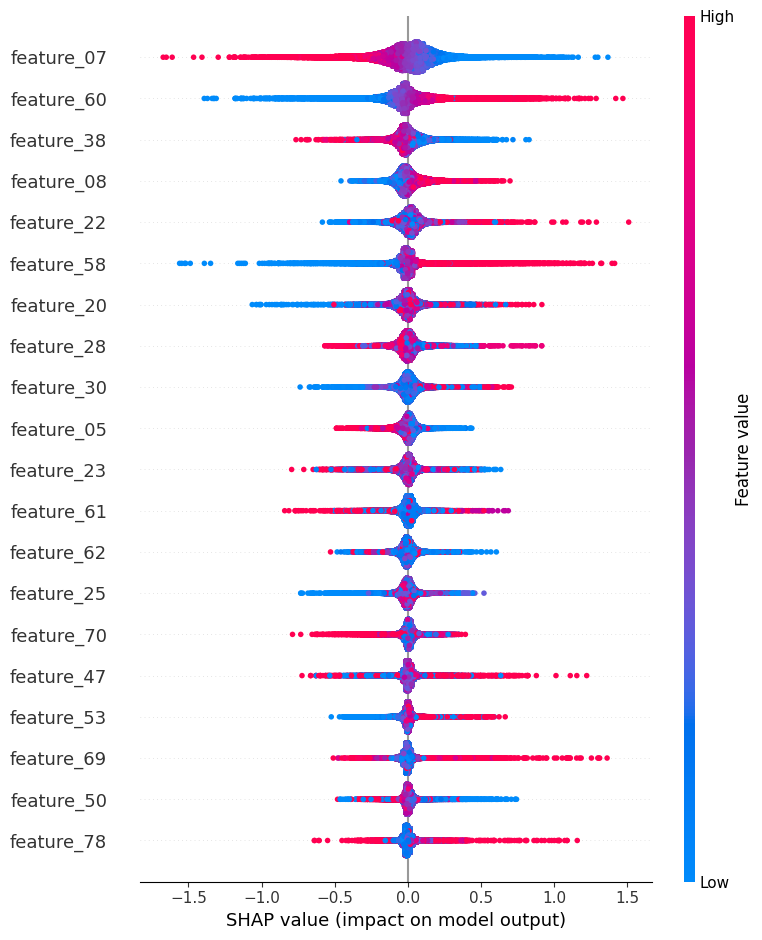

In [22]:
# Generate SHAP Summary Plot
shap.summary_plot(shap_values, X_sample)

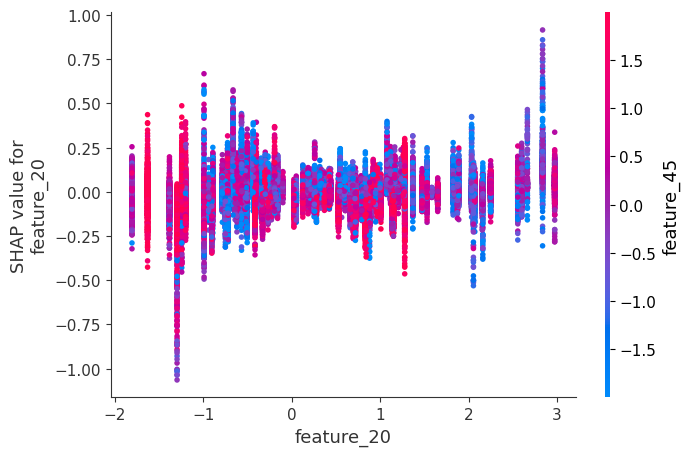

In [23]:
# SHAP Dependence Plot for Top Feature
shap.dependence_plot(top_30_features[0], shap_values.values, X_sample)

In [ ]:
# Investigate feature interactions

import shap

# Compute SHAP interaction values (this may take time!)
shap_interaction_values = shap.TreeExplainer(lgb_model_top30_final).shap_interaction_values(X_test)

# Plot interaction between two highly important features (e.g., feature_20 and feature_45)
shap.dependence_plot(
    ("feature_20", "feature_45"), shap_interaction_values, X_test, show=True
)

In [ ]:
import pandas as pd
import joblib

# Define paths
data_path = "/Users/caroline/Documents/TUM/Python/MarketForecasting/data/cleaned/day0_data_cleaned.parquet"
features_path = "/Users/caroline/Documents/TUM/Python/MarketForecasting/models/feature_importance.pkl"

# Load the cleaned dataset
data = pd.read_parquet(data_path)
print("Cleaned data loaded successfully.")

# Load the selected top 30 features
top_30_features = joblib.load(features_path)
print(f"Loaded {len(top_30_features)} top features.")

# Extract features (X) and target variable (y)
X = data[top_30_features]  # Use only the top 30 features
y = data["responder_6"]    # The target variable

# Display the shape of the dataset
print(f"Feature matrix shape: {X.shape}")
print(f"Target variable shape: {y.shape}")

Cleaned data loaded successfully.
Loaded 56 top features.
Feature matrix shape: (1944210, 57)
Target variable shape: (1944210,)
